In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
# Step 1: Import Libraries
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df_1 = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
df_2 = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

train_df = df_1.copy()
test_df = df_2.copy()

In [4]:
train_df.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

Text(0.5, 1.0, 'Target distribution')

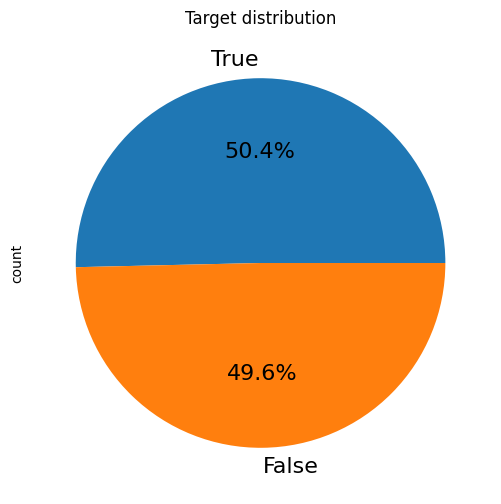

In [36]:
plt.figure(figsize=(6,6))

# Pie plot
train_df['Transported'].value_counts().plot.pie( autopct='%1.1f%%', textprops={'fontsize':16}).set_title("Target distribution")

Text(0.5, 0, 'Age (years)')

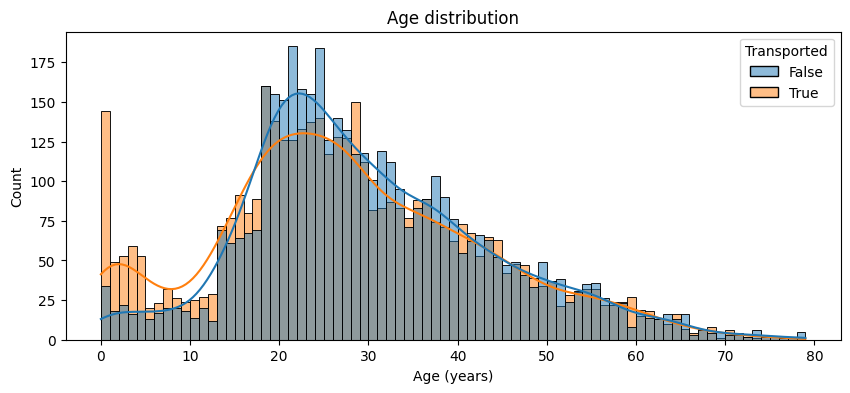

In [37]:
# Figure size
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=train_df, x='Age', hue='Transported', binwidth=1, kde=True)

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

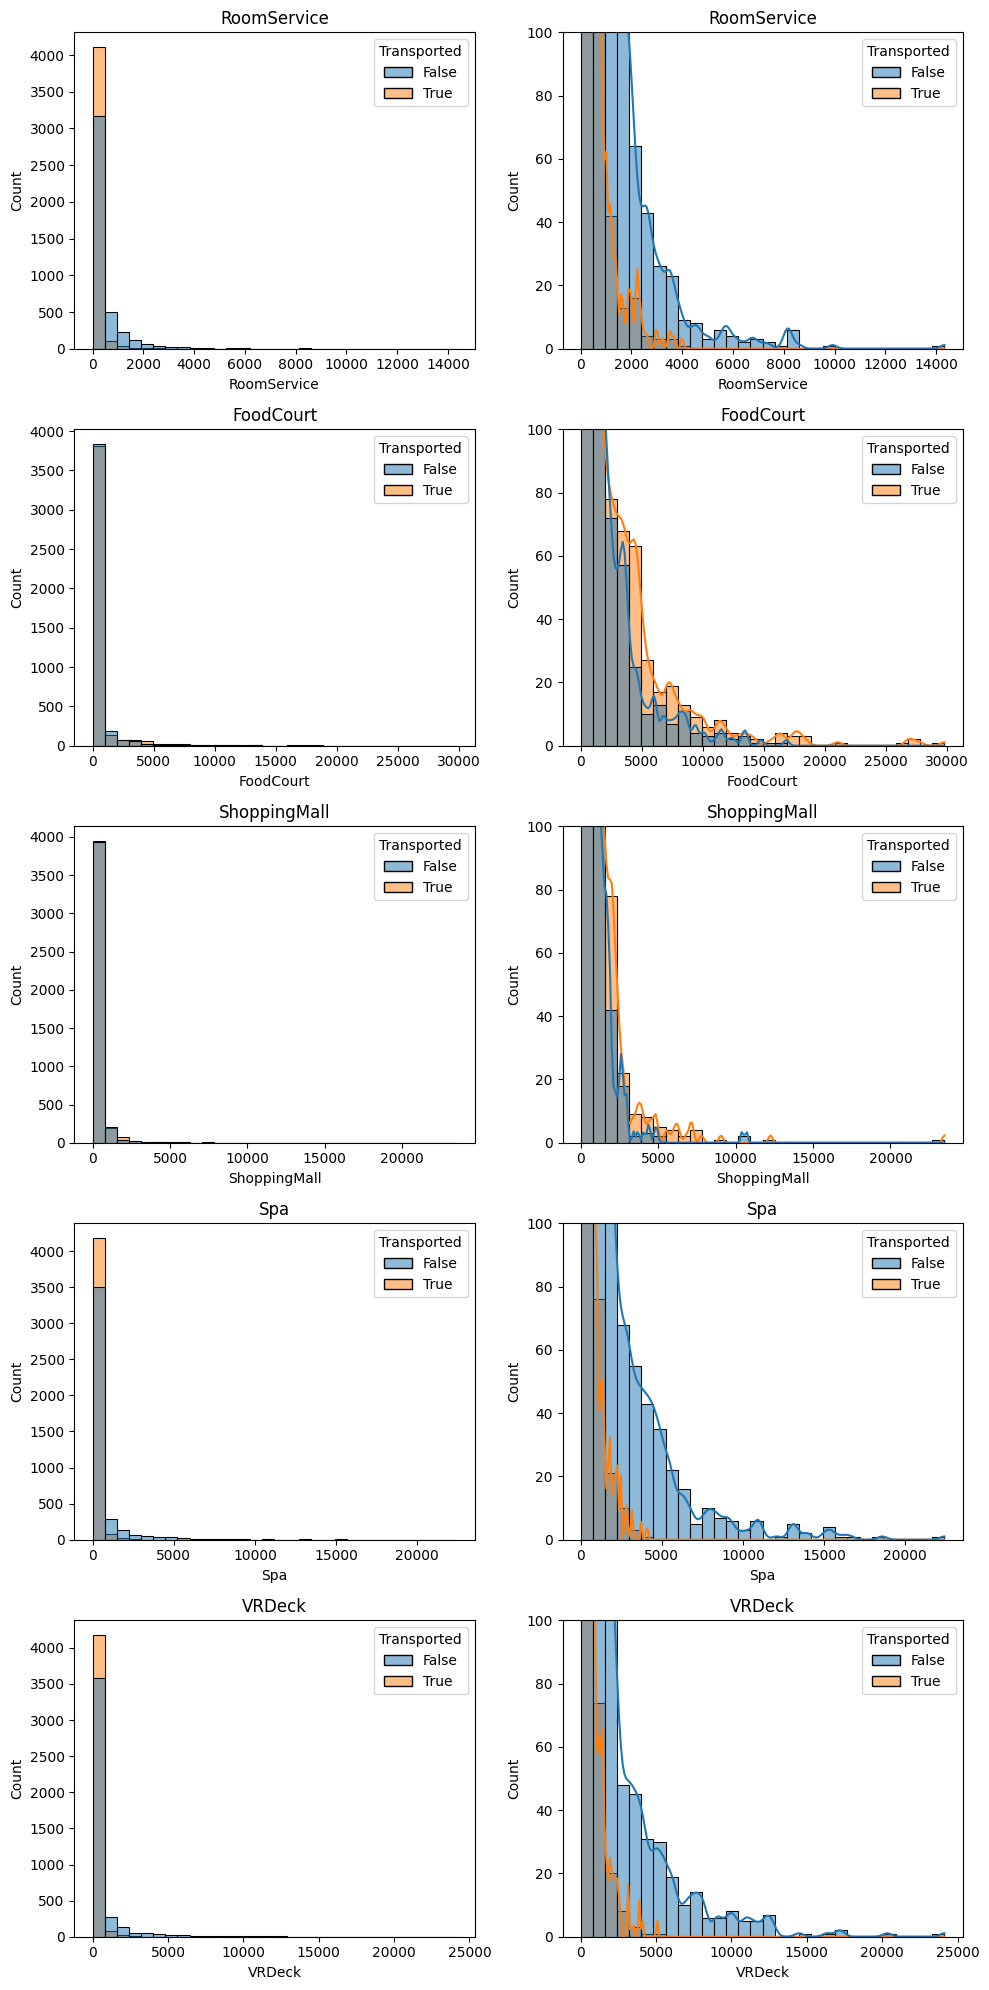

In [40]:
# Expenditure features
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot expenditure features
fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(exp_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=train_df, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    
    # Right plot (truncated)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=train_df, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout() 
plt.show()

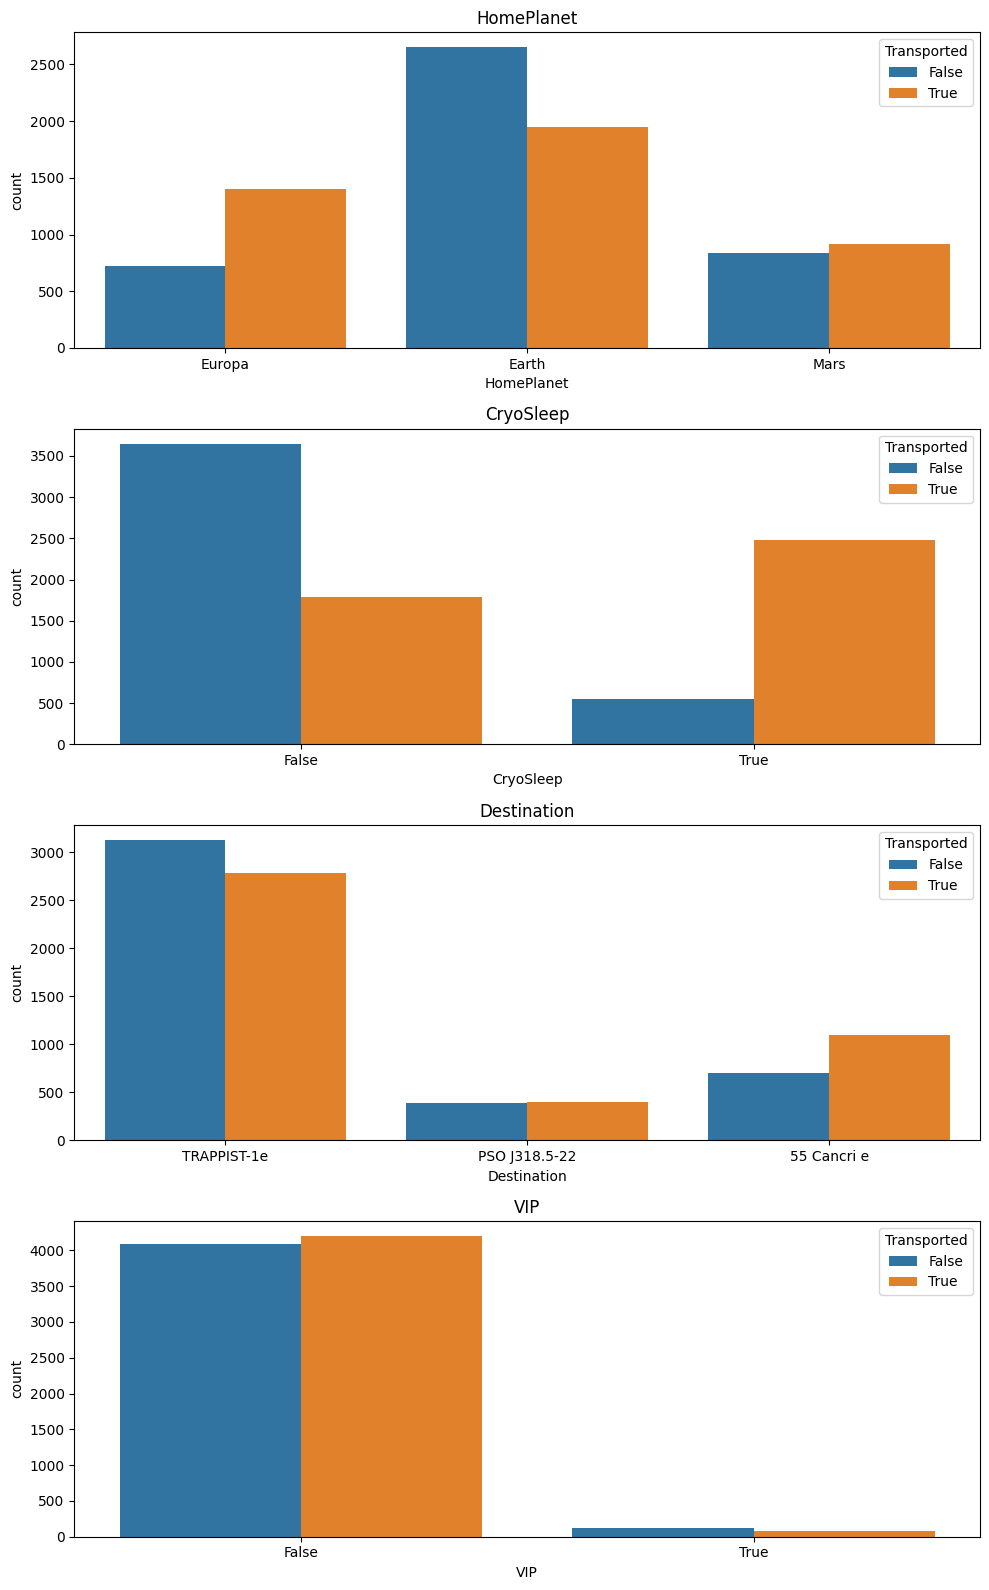

In [41]:
# Categorical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=train_df, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

In [5]:
drop_columns = ['PassengerId', 'Name', 'Transported']

X = train_df.drop(columns=drop_columns)
y = train_df.Transported

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

num_features = [feature for feature in X_train.columns if X_train[feature].dtype in ['int64', 'float64']]
cat_features = [feature for feature in X_train.columns if X_train[feature].nunique() < 10 and X_train[feature].dtype == "object"]

my_cols = cat_features + num_features
X_train = X_train[my_cols].copy()
X_val = X_val[my_cols].copy()
X_test = test_df[my_cols].copy()

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Step 5: Feature Scaling
# Scaling Numerical Features
num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Full pipeline
preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [7]:
param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# Fit GridSearchCV to the data
grid_search.fit(X_train, y_train)

# Extract best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

In [8]:
pipeline.set_params(**best_params)
pipeline.fit(X_train, y_train)
y_val_pred = pipeline.predict(X_val)
accuracy = classification_report(y_val, y_val_pred)
print(f"Accuracy: {accuracy}")

Accuracy:               precision    recall  f1-score   support

       False       0.81      0.75      0.78       861
        True       0.77      0.82      0.80       878

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



In [9]:
# Step 11: Final Model Training
pipeline.fit(X, y)

# Step 12: Predictions on Test Data
y_pred_test = pipeline.predict(X_test)

In [10]:
submission = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Transported': y_pred_test})
submission.to_csv('submission.csv', index=False)

In [14]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier

In [15]:
xgb_model = XGBClassifier(
    learning_rate=0.01, 
    n_estimators=400, 
    objective='binary:logistic',
    nthread=1
)

In [16]:
pipeline_xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

In [17]:
params_xgb = {
    'classifier__min_child_weight': [1, 5, 7, 10],
    'classifier__gamma': [0.2, 0.5, 1, 1.5, 2, 5],
    'classifier__subsample': [0.4, 0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.4, 0.6, 0.8, 1.0],
    'classifier__max_depth': [2, 3, 4, 5, 6, 7],
    'classifier__learning_rate': [0.001, 0.01, 0.1],
    'classifier__n_estimators': [100, 200, 400, 600]
}

folds = 20
param_comb = 20
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(pipeline_xgb, param_distributions=params_xgb, n_iter=param_comb, scoring='accuracy',n_jobs=4, cv=skf.split(X_train,y_train), verbose=3, random_state=1001 )
random_search.fit(X_train, y_train)

Fitting 20 folds for each of 20 candidates, totalling 400 fits
[CV 3/20] END classifier__colsample_bytree=0.8, classifier__gamma=0.5, classifier__learning_rate=0.001, classifier__max_depth=5, classifier__min_child_weight=7, classifier__n_estimators=600, classifier__subsample=0.6;, score=0.828 total time=   6.4s
[CV 6/20] END classifier__colsample_bytree=0.8, classifier__gamma=0.5, classifier__learning_rate=0.001, classifier__max_depth=5, classifier__min_child_weight=7, classifier__n_estimators=600, classifier__subsample=0.6;, score=0.776 total time=   6.2s
[CV 10/20] END classifier__colsample_bytree=0.8, classifier__gamma=0.5, classifier__learning_rate=0.001, classifier__max_depth=5, classifier__min_child_weight=7, classifier__n_estimators=600, classifier__subsample=0.6;, score=0.799 total time=   6.8s
[CV 15/20] END classifier__colsample_bytree=0.8, classifier__gamma=0.5, classifier__learning_rate=0.001, classifier__max_depth=5, classifier__min_child_weight=7, classifier__n_estimators

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7cab24a3c270>,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Age',
                                                                                'RoomService',
                                                                                'FoodCourt',
                                                                                'ShoppingMall',
                                                                                'Spa',
                                                                                'VRDeck']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleI...
                   param_distributions={'classifier__colsample_bytree': [0.4,
                                                                         0.6,
                                                                         0.8,
                                                                         1.0],
                                        'classifier__gamma': [0.2, 0.5, 1, 1.5,
                                                              2, 5],
                                        'classifier__learning_rate': [0.001,
                                                                      0.01,
                                                                      0.1],
                                        'classifier__max_depth': [2, 3, 4, 5, 6,
                                                                  7],
                                        'classifier__min_child_weight': [1, 5,
                                                                         7,
                                                                         10],
                                        'classifier__n_estimators': [100, 200,
                                                                     400, 600],
                                        'classifier__subsample': [0.4, 0.6, 0.8,
                                                                  1.0]},
                   random_state=1001, scoring='accuracy', verbose=3)

[CV 13/20] END classifier__colsample_bytree=0.4, classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=7, classifier__n_estimators=200, classifier__subsample=0.8;, score=0.799 total time=   1.1s
[CV 16/20] END classifier__colsample_bytree=0.4, classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=7, classifier__n_estimators=200, classifier__subsample=0.8;, score=0.758 total time=   1.1s
[CV 14/20] END classifier__colsample_bytree=0.4, classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=7, classifier__n_estimators=200, classifier__subsample=0.8;, score=0.790 total time=   1.5s
[CV 18/20] END classifier__colsample_bytree=0.4, classifier__gamma=0.5, classifier__learning_rate=0.1, classifier__max_depth=3, classifier__min_child_weight=7, classifier__n_estimators=200, classifier__subsample=0.8;, score=0.775 total time=   0.9s
[CV 

In [18]:
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best hyperparameters:
{'classifier__subsample': 0.8, 'classifier__n_estimators': 200, 'classifier__min_child_weight': 7, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0.5, 'classifier__colsample_bytree': 0.4}


In [19]:
pipeline_xgb.set_params(**random_search.best_params_)
pipeline_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'RoomService',
                                                   'FoodCourt', 'ShoppingMall',
                                                   'Spa', 'VRDeck']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'...
                               feature_types=None, gamma=0.5, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None, min_child_weight=7,
                               missing=nan, monotone_constraints=None,
                               n_estimators=200, n_jobs=None, nthread=1,
                               num_parallel_tree=None, predictor=None, ...))])

In [21]:
y_val_xgb_pred = pipeline_xgb.predict(X_val)
accuracy = classification_report(y_val, y_val_xgb_pred)
print(f"Accuracy: {accuracy}")

Accuracy:               precision    recall  f1-score   support

       False       0.82      0.74      0.78       861
        True       0.77      0.84      0.80       878

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



In [22]:
# Step 11: Final Model Training
pipeline_xgb.fit(X, y)

# Step 12: Predictions on Test Data
y_pred_test_xgb = pipeline_xgb.predict(X_test)

In [28]:
submission_xgb = pd.DataFrame({'PassengerId': test_df['PassengerId'], 'Transported': y_pred_test_xgb})
submission_xgb['Transported'] = submission_xgb['Transported'].replace({0: False, 1: True})
submission_xgb.to_csv('submission_xgb.csv', index=False)